### 1 导入包 

In [1]:
from transformers import AutoConfig,AutoModel,AutoTokenizer,AdamW,get_linear_schedule_with_warmup,logging
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset,SequentialSampler,RandomSampler,DataLoader

import pandas as pd

# 导入transformers
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

# 导入torch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# 常用包
import re
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from collections import defaultdict
from textwrap import wrap
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina' # 主题

In [2]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
torch.cuda.is_available()

True

### 2 加载数据

In [4]:
f1 = open(r"C:\Users\pepperbox\Desktop\graduation paper\数据\book_data_inMA_with_level1and2.txt", "r", encoding = 'utf-8')

In [5]:
data = eval(f1.readline())

In [6]:
df = pd.DataFrame(data)
df

,title,abstract,top_topics,citing_articles,tags,tags_1and2
0,Turn Left at Orion: A Hundred Night Sky Object...,Preface 1. How to use this book 2. The Moon 3....,"[Astronomy, Geography, Night sky, Telescope, G...",[],"[Night sky, Telescope, Planet, Glossary, Astro...","[Linguistics, Astronomy, Optics, Geography, As..."
1,Project Management Tools and Techniques for Su...,Emphasizing that it is easier and more cost ef...,"[Engineering, Project management, Project mana...",[Investing in project management certification...,"[Project management triangle, Project charter,...","[Management science, Management, Engineering, ..."
2,Human Rights in International Investment Law a...,1. I INTRODUCTION AND SUMMARY OF THE BOOK Intr...,"[Arbitration, Human rights, Political science,...",[Foreign investment and the environment in int...,"[International human rights law, Human rights,...","[Political science, Law]"
3,Locating Science Fiction,,"[Media studies, Art history, History]",[],"[Art history, History, Media studies]","[History, Media studies, Art history]"
4,Avenues to Adulthood: The Origins of the High ...,,"[Gender studies, Sociology, Social mobility]",[],"[Social mobility, Sociology, Gender studies]","[Gender studies, Social science, Sociology]"
...,...,...,...,...,...,...
36449,Galileische Idealisierung Ein pragmatisches Ko...,,"[Philosophy of science, Epistemology, Philosophy]","[Modellbildung in den Sozialwissenschaften, Mi...","[Philosophy of science, Philosophy, Epistemology]","[Epistemology, Philosophy]"
36450,Herrlichkeit Zur Deutung einer theologischen K...,,[Philosophy],[Metaphysics And Testimonial Knowledge In The ...,[Philosophy],[Philosophy]
36451,The Alga Dunaliella,,"[Chemistry, Dunaliella, Botany]",[Transcriptome sequencing and annotation of th...,"[Dunaliella, Botany, Chemistry]","[Botany, Chemistry]"
36452,Understanding Child Development,,"[Child development, Developmental psychology, ...",[Clinical Practice Guideline for the Managemen...,"[Child development, Psychology, Developmental ...","[Psychiatry, Developmental psychology, Psychol..."


In [7]:
# 去掉tags_1and2字段为空([])的数据
df = df.loc[df["tags_1and2"].str.len() != 0]
df

,title,abstract,top_topics,citing_articles,tags,tags_1and2
0,Turn Left at Orion: A Hundred Night Sky Object...,Preface 1. How to use this book 2. The Moon 3....,"[Astronomy, Geography, Night sky, Telescope, G...",[],"[Night sky, Telescope, Planet, Glossary, Astro...","[Linguistics, Astronomy, Optics, Geography, As..."
1,Project Management Tools and Techniques for Su...,Emphasizing that it is easier and more cost ef...,"[Engineering, Project management, Project mana...",[Investing in project management certification...,"[Project management triangle, Project charter,...","[Management science, Management, Engineering, ..."
2,Human Rights in International Investment Law a...,1. I INTRODUCTION AND SUMMARY OF THE BOOK Intr...,"[Arbitration, Human rights, Political science,...",[Foreign investment and the environment in int...,"[International human rights law, Human rights,...","[Political science, Law]"
3,Locating Science Fiction,,"[Media studies, Art history, History]",[],"[Art history, History, Media studies]","[History, Media studies, Art history]"
4,Avenues to Adulthood: The Origins of the High ...,,"[Gender studies, Sociology, Social mobility]",[],"[Social mobility, Sociology, Gender studies]","[Gender studies, Social science, Sociology]"
...,...,...,...,...,...,...
36449,Galileische Idealisierung Ein pragmatisches Ko...,,"[Philosophy of science, Epistemology, Philosophy]","[Modellbildung in den Sozialwissenschaften, Mi...","[Philosophy of science, Philosophy, Epistemology]","[Epistemology, Philosophy]"
36450,Herrlichkeit Zur Deutung einer theologischen K...,,[Philosophy],[Metaphysics And Testimonial Knowledge In The ...,[Philosophy],[Philosophy]
36451,The Alga Dunaliella,,"[Chemistry, Dunaliella, Botany]",[Transcriptome sequencing and annotation of th...,"[Dunaliella, Botany, Chemistry]","[Botany, Chemistry]"
36452,Understanding Child Development,,"[Child development, Developmental psychology, ...",[Clinical Practice Guideline for the Managemen...,"[Child development, Psychology, Developmental ...","[Psychiatry, Developmental psychology, Psychol..."


In [8]:
df1 = pd.concat([df['title'], df['citing_articles'], df['tags_1and2']], axis=1)
df1

,title,citing_articles,tags_1and2
0,Turn Left at Orion: A Hundred Night Sky Object...,[],"[Linguistics, Astronomy, Optics, Geography, As..."
1,Project Management Tools and Techniques for Su...,[Investing in project management certification...,"[Management science, Management, Engineering, ..."
2,Human Rights in International Investment Law a...,[Foreign investment and the environment in int...,"[Political science, Law]"
3,Locating Science Fiction,[],"[History, Media studies, Art history]"
4,Avenues to Adulthood: The Origins of the High ...,[],"[Gender studies, Social science, Sociology]"
...,...,...,...
36449,Galileische Idealisierung Ein pragmatisches Ko...,"[Modellbildung in den Sozialwissenschaften, Mi...","[Epistemology, Philosophy]"
36450,Herrlichkeit Zur Deutung einer theologischen K...,[Metaphysics And Testimonial Knowledge In The ...,[Philosophy]
36451,The Alga Dunaliella,[Transcriptome sequencing and annotation of th...,"[Botany, Chemistry]"
36452,Understanding Child Development,[Clinical Practice Guideline for the Managemen...,"[Psychiatry, Developmental psychology, Psychol..."


In [9]:
df1.rename(columns={'tags_1and2':'categories'},inplace=True) 

In [10]:
df1

,title,citing_articles,categories
0,Turn Left at Orion: A Hundred Night Sky Object...,[],"[Linguistics, Astronomy, Optics, Geography, As..."
1,Project Management Tools and Techniques for Su...,[Investing in project management certification...,"[Management science, Management, Engineering, ..."
2,Human Rights in International Investment Law a...,[Foreign investment and the environment in int...,"[Political science, Law]"
3,Locating Science Fiction,[],"[History, Media studies, Art history]"
4,Avenues to Adulthood: The Origins of the High ...,[],"[Gender studies, Social science, Sociology]"
...,...,...,...
36449,Galileische Idealisierung Ein pragmatisches Ko...,"[Modellbildung in den Sozialwissenschaften, Mi...","[Epistemology, Philosophy]"
36450,Herrlichkeit Zur Deutung einer theologischen K...,[Metaphysics And Testimonial Knowledge In The ...,[Philosophy]
36451,The Alga Dunaliella,[Transcriptome sequencing and annotation of th...,"[Botany, Chemistry]"
36452,Understanding Child Development,[Clinical Practice Guideline for the Managemen...,"[Psychiatry, Developmental psychology, Psychol..."


### 3 数据预处理处理

### 3.1 文本拼接

### 3.2  标签转换

In [11]:
labels = set()
for index, row in df1.iterrows():
    categories = row['categories']
    for category in categories:
        labels.add(category)

In [12]:
labels = list(labels)

In [13]:
len(labels)

311

In [14]:
results = []
for index, row in df1.iterrows():
    title = row['title']
    if pd.isna(title):
        title = ''
    categories = row['categories']
    citing_articles = str(row['citing_articles']).replace('[',' ').replace(']',' ')
    if pd.isna(citing_articles):
        citing_articles = ''
    text = title + " " + citing_articles
    labels_id = [0] * len(labels) 
    for category in categories:
        labels_id[labels.index(category)] = 1
    results.append([text] + labels_id)

In [15]:
label_columns = [f'label{i}' for i in range(len(labels))]

In [16]:
df2 = pd.DataFrame(results, columns=['text'] + label_columns)

In [17]:
df2

,text,label0,label1,label2,label3,label4,label5,label6,label7,label8,...,label301,label302,label303,label304,label305,label306,label307,label308,label309,label310
0,Turn Left at Orion: A Hundred Night Sky Object...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Project Management Tools and Techniques for Su...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Human Rights in International Investment Law a...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Locating Science Fiction,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Avenues to Adulthood: The Origins of the High ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36441,Galileische Idealisierung Ein pragmatisches Ko...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36442,Herrlichkeit Zur Deutung einer theologischen K...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36443,The Alga Dunaliella 'Transcriptome sequencing...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36444,Understanding Child Development 'Clinical Pra...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [19]:
token_lens = []

for txt in tqdm(df2.text):
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

100%|███████████████████████████████████████████████████████████████████████████| 36446/36446 [00:54<00:00, 672.82it/s]


C:\py_and_conda\anaconda3\envs\pytorch\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


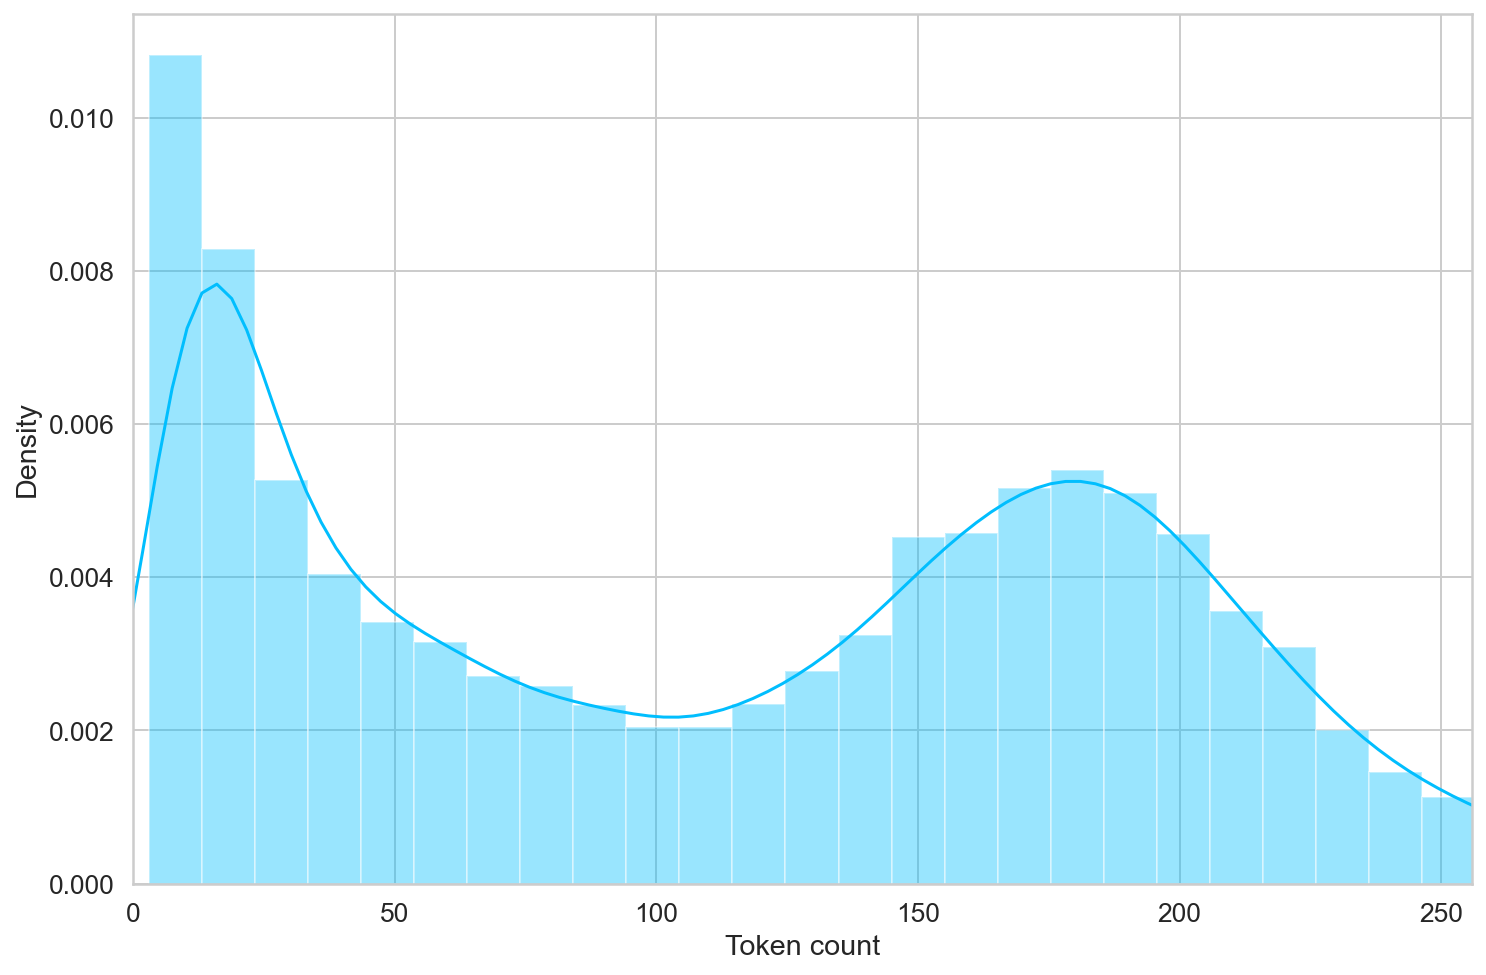

In [20]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [21]:
pd.Series(token_lens).describe()

count    36446.000000
mean       117.143088
std         80.951202
min          3.000000
25%         34.000000
50%        125.000000
75%        184.000000
max        510.000000
dtype: float64

In [22]:
MAX_LEN=256

### 5 构建学术论文数据集

### 5.1 自定义数据集

In [23]:
class PaperDataset(Dataset):
    def __init__(self,texts,labels,tokenizer,max_len):
        self.texts=texts
        self.labels=labels
        self.tokenizer=tokenizer
        self.max_len=max_len
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self,item):
        """
        item 为数据索引，迭代取第item条数据
        """
        text=str(self.texts[item])
        label=self.labels[item]
        
        encoding=self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
#         print(encoding['input_ids'])
        return {
            'texts':text,
            'input_ids':encoding['input_ids'].flatten(),
            'attention_mask':encoding['attention_mask'].flatten(),
            'labels':torch.tensor(label,dtype=torch.long)
        }
        

### 5.2 划分数据集并创建生成器

In [24]:
df_train, df_test = train_test_split(df2, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_train.shape, df_val.shape, df_test.shape

((32801, 312), (1822, 312), (1823, 312))

In [25]:
def create_data_loader(df,tokenizer,max_len,batch_size):
    ds=PaperDataset(
        texts=df['text'].values,
        labels=df[label_columns].values,
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
#         num_workers=4 # windows多线程
    )

In [26]:
BATCH_SIZE = 8

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

## 6 基于Huggingface 的学术论文分类模型构建

![](https://pic1.zhimg.com/80/v2-edafe957e971fe53feeadd2477706cf4_720w.jpg)

In [27]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### 定义分类模型

In [28]:
class PaperClassifier(nn.Module):
    def __init__(self, n_classes):
        super(PaperClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict = False
        )
        output = self.drop(pooled_output) # dropout
        return self.out(output)

In [29]:
class_names=labels
class_names

['Law',
 'Veterinary medicine',
 'Food science',
 'Physical geography',
 'Pattern recognition',
 'Engineering drawing',
 'Biomedical engineering',
 'Mathematical physics',
 'Genealogy',
 'Soil science',
 'Economy',
 'Nursing',
 'Engineering ethics',
 'Medical physics',
 'Economics',
 'Dermatology',
 'Crystallography',
 'Seismology',
 'Public administration',
 'Visual arts',
 'Mineralogy',
 'Computer hardware',
 'Physics',
 'Keynesian economics',
 'Nanotechnology',
 'Medicine',
 'Geochemistry',
 'Physical medicine and rehabilitation',
 'Fishery',
 'Medical emergency',
 'Analytical chemistry',
 'Petroleum engineering',
 'Geology',
 'Audiology',
 'Environmental health',
 'Transport engineering',
 'Dentistry',
 'Construction engineering',
 'Endocrinology',
 'Biochemistry',
 'Accounting',
 'Anesthesia',
 'Development economics',
 'World Wide Web',
 'Cell biology',
 'Nuclear medicine',
 'Andrology',
 'Multimedia',
 'Public relations',
 'Remote sensing',
 'Zoology',
 'Management',
 'Speech re

In [30]:
len(class_names)

311

In [31]:
model = PaperClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## 7 模型训练

In [32]:
EPOCHS = 10 # 训练轮数

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.BCEWithLogitsLoss().to(device)

In [33]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
    model = model.train()
    losses = []
    preds = []
    trues = []
    for d in tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["labels"].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        loss = loss_fn(outputs, targets.float())
        trues.append(targets.cpu().detach().numpy())
        outputs = torch.sigmoid(outputs)
        preds.append(outputs.cpu().detach().numpy())
        losses.append(loss.item())
        loss.backward()
#         nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    trues = np.vstack(trues)
    preds = np.vstack(preds)
    precision = precision_score(trues.astype(int), (preds > 0.5).astype(int), average='micro')
    recall= recall_score(trues.astype(int), (preds > 0.5).astype(int), average='micro')
    f1 = f1_score(trues.astype(int), (preds > 0.5).astype(int), average='micro')
    return precision, recall, f1, np.mean(losses)

In [34]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval() # 验证预测模式

    losses = []
    preds = []
    trues = []
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            loss = loss_fn(outputs, targets.float())
            trues.append(targets.cpu().detach().numpy())
            outputs = torch.sigmoid(outputs)
            preds.append(outputs.cpu().detach().numpy())
            losses.append(loss.item())
    trues = np.vstack(trues)
    preds = np.vstack(preds)
    precision = precision_score(trues.astype(int), (preds > 0.5).astype(int), average='micro')
    recall= recall_score(trues.astype(int), (preds > 0.5).astype(int), average='micro')
    f1 = f1_score(trues.astype(int), (preds > 0.5).astype(int), average='micro')
    return precision, recall, f1, np.mean(losses)

In [35]:
history = defaultdict(list) # 记录10轮loss和acc
best_f1 = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_precision, train_recall, train_f1, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f'Train loss {train_loss} f1 {train_f1}')

    val_precision, val_recall, val_f1, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f'Val   loss {val_loss} f1 {val_f1}')
    print()

    history['train_precision'].append(train_precision)
    history['train_recall'].append(train_recall)
    history['train_f1'].append(train_f1)
    history['train_loss'].append(train_loss)
    history['val_precision'].append(val_precision)
    history['val_recall'].append(val_recall)
    history['val_f1'].append(val_f1)
    history['val_loss'].append(val_loss)

    if val_f1 > best_f1:
        torch.save(model.state_dict(), 'best_model_state_0.5_title+citing.bin')
        best_f1 = val_f1


  0%|                                                                                         | 0/4101 [00:00<?, ?it/s]

Epoch 1/10
----------


C:\py_and_conda\anaconda3\envs\pytorch\lib\site-packages\transformers\tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████████████████████████████████████████████████████████████████████████| 4101/4101 [23:52<00:00,  2.86it/s]


Train loss 0.06258369834084855 f1 0.018085059814521832
Val   loss 0.05048683895157617 f1 0.07172701949860724



  0%|                                                                                         | 0/4101 [00:00<?, ?it/s]

Epoch 2/10
----------


100%|██████████████████████████████████████████████████████████████████████████████| 4101/4101 [23:55<00:00,  2.86it/s]


Train loss 0.04736038109333493 f1 0.18684935030015373
Val   loss 0.0445410500345915 f1 0.24124356515595033



  0%|                                                                                         | 0/4101 [00:00<?, ?it/s]

Epoch 3/10
----------


100%|██████████████████████████████████████████████████████████████████████████████| 4101/4101 [24:00<00:00,  2.85it/s]


Train loss 0.04262019819799166 f1 0.2981819733697508
Val   loss 0.042728535757449115 f1 0.2898025374415721



  0%|                                                                                         | 0/4101 [00:00<?, ?it/s]

Epoch 4/10
----------


100%|██████████████████████████████████████████████████████████████████████████████| 4101/4101 [23:51<00:00,  2.86it/s]


Train loss 0.0397917843210086 f1 0.36195405162202143
Val   loss 0.04198824736011917 f1 0.3219404630650496



  0%|                                                                                         | 0/4101 [00:00<?, ?it/s]

Epoch 5/10
----------


100%|██████████████████████████████████████████████████████████████████████████████| 4101/4101 [23:55<00:00,  2.86it/s]


Train loss 0.037690618273231405 f1 0.40690452187169585
Val   loss 0.0415833360156077 f1 0.34479064369252743



  0%|                                                                                         | 0/4101 [00:00<?, ?it/s]

Epoch 6/10
----------


100%|██████████████████████████████████████████████████████████████████████████████| 4101/4101 [23:52<00:00,  2.86it/s]


Train loss 0.035935381014318805 f1 0.44644321172922663
Val   loss 0.0413618735119439 f1 0.36251089799476904



  0%|                                                                                         | 0/4101 [00:00<?, ?it/s]

Epoch 7/10
----------


100%|██████████████████████████████████████████████████████████████████████████████| 4101/4101 [23:55<00:00,  2.86it/s]


Train loss 0.03456343797604846 f1 0.4740601415371594
Val   loss 0.041196222539599 f1 0.3787671232876712



  0%|                                                                                         | 0/4101 [00:00<?, ?it/s]

Epoch 8/10
----------


100%|██████████████████████████████████████████████████████████████████████████████| 4101/4101 [23:52<00:00,  2.86it/s]


Train loss 0.033448198982585976 f1 0.4964888585657463


  0%|                                                                                         | 0/4101 [00:00<?, ?it/s]

Val   loss 0.04124136626916496 f1 0.3774262505344164

Epoch 9/10
----------


100%|██████████████████████████████████████████████████████████████████████████████| 4101/4101 [23:52<00:00,  2.86it/s]


Train loss 0.03265070858289086 f1 0.5119528054005053
Val   loss 0.041098565149137324 f1 0.38242057746358915



  0%|                                                                                         | 0/4101 [00:00<?, ?it/s]

Epoch 10/10
----------


100%|██████████████████████████████████████████████████████████████████████████████| 4101/4101 [23:55<00:00,  2.86it/s]


Train loss 0.0321480833419563 f1 0.520849551686556
Val   loss 0.04082590981239551 f1 0.3883593420497681



In [36]:
history

defaultdict(list,
            {'train_precision': [0.1191790983268771,
              0.6859362259130509,
              0.7043701799485861,
              0.7276629668240633,
              0.7445246279266471,
              0.7658195575294021,
              0.7768582304621882,
              0.7902894546314219,
              0.7999856187531459,
              0.8055697206640603],
             'train_recall': [0.009784947691807983,
              0.10815547645793014,
              0.18912152011801486,
              0.24088835956637658,
              0.27995371435531674,
              0.3150536615734412,
              0.34110625397555794,
              0.36193479408301643,
              0.3764227422214403,
              0.38483400776840937],
             'train_f1': [0.018085059814521832,
              0.18684935030015373,
              0.2981819733697508,
              0.36195405162202143,
              0.40690452187169585,
              0.44644321172922663,
              0.4740601415371594,


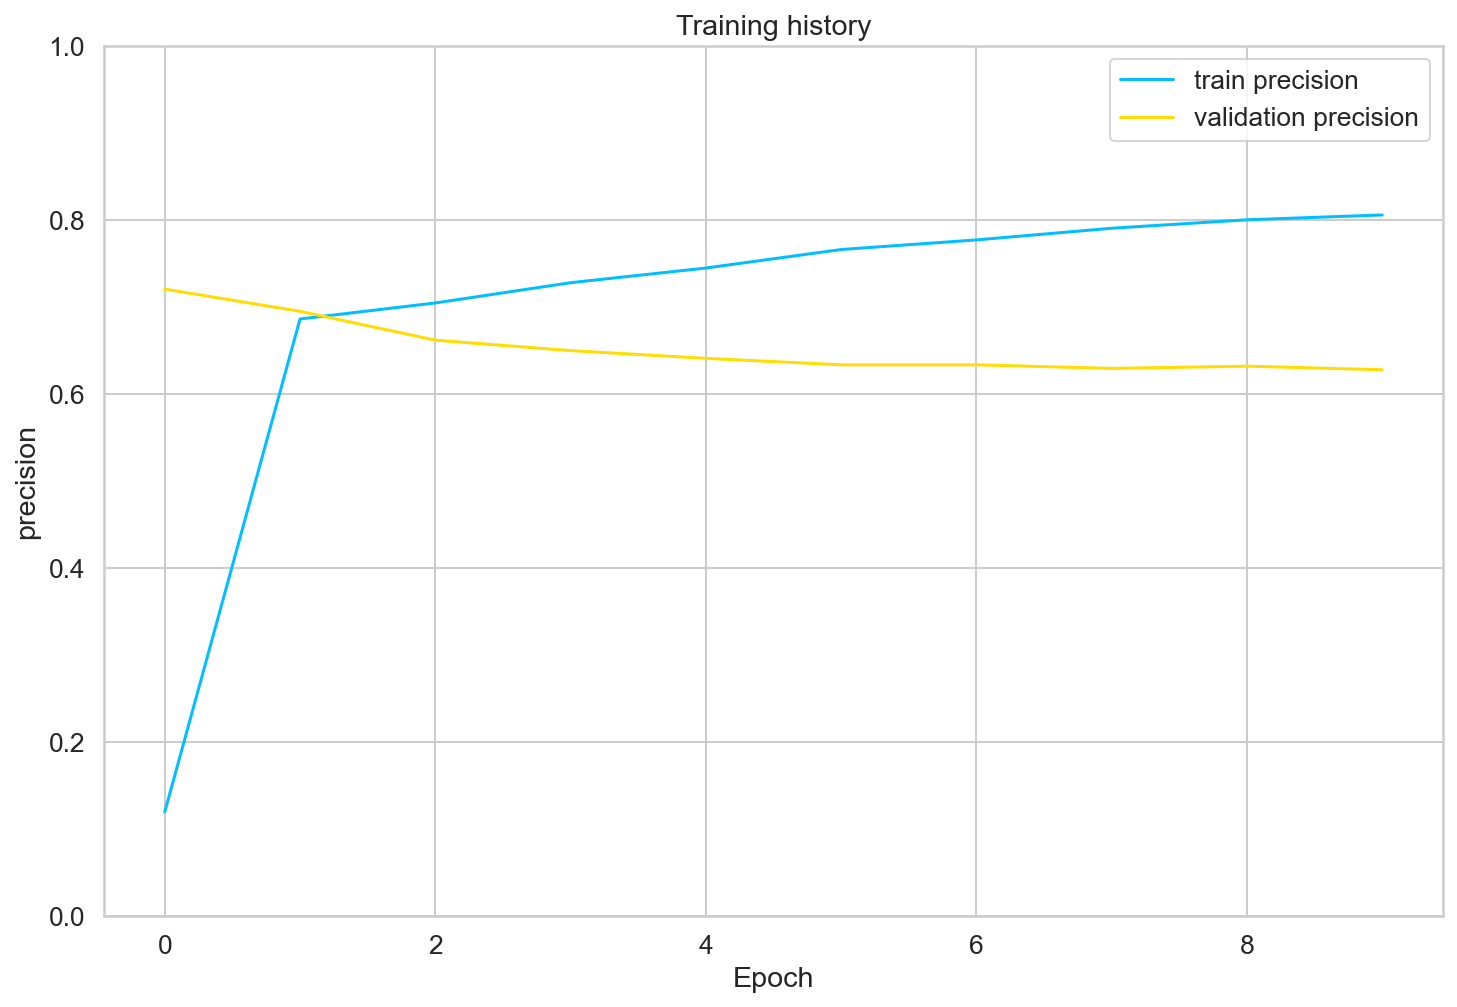

In [37]:
plt.plot(history['train_precision'], label='train precision')
plt.plot(history['val_precision'], label='validation precision')

plt.title('Training history')
plt.ylabel('precision')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

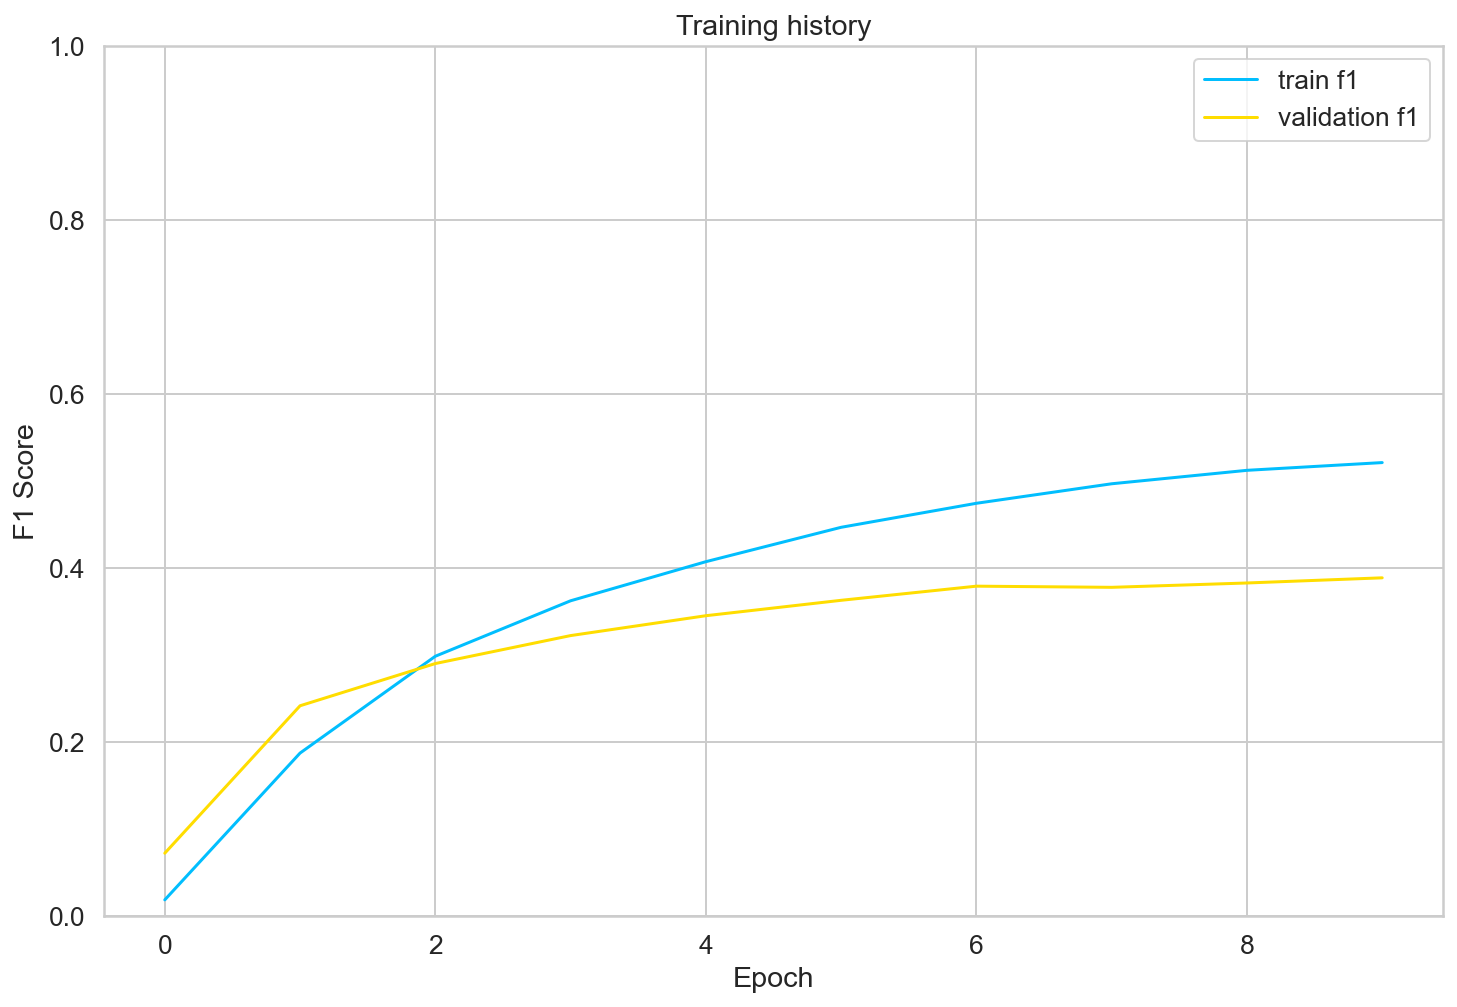

In [38]:
plt.plot(history['train_f1'], label='train f1')
plt.plot(history['val_f1'], label='validation f1')

plt.title('Training history')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### 8 模型评估

In [39]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    preds = []
    trues = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["texts"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            trues.append(targets.cpu().detach().numpy())
            outputs = torch.sigmoid(outputs)
            preds.append(outputs.cpu().detach().numpy())

        trues = np.vstack(trues)
        preds = np.vstack(preds)
    return texts, preds, trues

In [40]:
y_texts, y_preds, y_trues = get_predictions(
  model,
  test_data_loader
)

In [41]:
y_trues.shape

(1823, 311)

In [42]:
y_preds.shape

(1823, 311)

In [43]:
print(classification_report(y_trues.astype(int), (y_preds > 0.5).astype(int), target_names=class_names))

                                      precision    recall  f1-score   support

                                 Law       0.66      0.56      0.61       100
                 Veterinary medicine       0.00      0.00      0.00         5
                        Food science       0.00      0.00      0.00        18
                  Physical geography       0.00      0.00      0.00         5
                 Pattern recognition       0.00      0.00      0.00         1
                 Engineering drawing       0.00      0.00      0.00         4
              Biomedical engineering       0.00      0.00      0.00         2
                Mathematical physics       0.00      0.00      0.00         7
                           Genealogy       0.00      0.00      0.00        23
                        Soil science       0.00      0.00      0.00         1
                             Economy       0.33      0.03      0.06        31
                             Nursing       0.80      0.19      

C:\py_and_conda\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\py_and_conda\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\py_and_conda\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
np.save("y_trues_title+citing.npy",y_trues)
np.save("y_preds_title+citing.npy",y_preds)